# 628 Project: BTC Order Book Processing and Mid-Price Direction Prediction

This notebook processes local Binance L2 order book data for BTCUSDT, builds basic microstructure features,
and trains classic mL classifiers (Random Forest, SVM, Gradient Boosting ++ XGBoost, LGBM) to predict whether the next 1-second
mid-price move is an upward or downward movement. Second half of the project will be focused on engineering features discussed in seminal papers by A.N. Kercheval and Zhang 

### Requirements
- Python 3.x
- `pandas`, `numpy`, `matplotlib`, `scikit-learn`

Install missing packages via `pip install pandas numpy matplotlib scikit-learn` in your environment.

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Add these to your existing imports
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance
import seaborn as sns

# --- Local directories (Windows) ---
# Update these if your folder structure changes
week1_dir = r"C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept"
week2_dir = r"C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_8Sept-14Sept"

print("Week 1 dir exists:", os.path.isdir(week1_dir))
print("Week 2 dir exists:", os.path.isdir(week2_dir))

Week 1 dir exists: True
Week 2 dir exists: True


In [6]:
# Collect all .data files from both weeks
data_files = []

for d in [week1_dir, week2_dir]:
    if not os.path.isdir(d):
        continue
    for fname in os.listdir(d):
        if fname.endswith('.data'):
            data_files.append(os.path.join(d, fname))

data_files = sorted(data_files)

print(f"Found {len(data_files)} data files:")
for f in data_files:
    print("  ", f)

Found 14 data files:
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-01_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-02_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-03_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-04_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-05_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-06_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-07_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_8Sept-14Sept\2025-09-08_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_8Sept-14Sept\2025-09-09_BTCUSDT_ob200.data
   C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_8Sept-14S

In [7]:
def parse_orderbook_file(file_path):
    """Parse a Binance OB .data file into a DataFrame with:
    - ts
    - best_bid_price, best_bid_quantity
    - best_ask_price, best_ask_quantity
    """
    rows = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                data = json.loads(line)
            except json.JSONDecodeError:
                # Skip malformed lines
                continue

            ts = data.get('ts')
            book = data.get('data', {})
            bids = book.get('b', [])
            asks = book.get('a', [])

            best_bid_price = bids[0][0] if bids else None
            best_bid_quantity = bids[0][1] if bids else None
            best_ask_price = asks[0][0] if asks else None
            best_ask_quantity = asks[0][1] if asks else None

            rows.append({
                'ts': ts,
                'best_bid_price': best_bid_price,
                'best_bid_quantity': best_bid_quantity,
                'best_ask_price': best_ask_price,
                'best_ask_quantity': best_ask_quantity,
            })

    df = pd.DataFrame(rows)
    return df

print('Parser ready.')

Parser ready.


In [8]:
all_dfs = []

for fp in data_files:
    print('Parsing:', fp)
    df_parsed = parse_orderbook_file(fp)
    print('  rows parsed:', len(df_parsed))
    if len(df_parsed) > 0:
        all_dfs.append(df_parsed)

if not all_dfs:
    raise RuntimeError('No dataframes were parsed. Check data files and parser.')

combined_df = pd.concat(all_dfs, ignore_index=True)
print('Combined shape:', combined_df.shape)
display(combined_df.head())

Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-01_BTCUSDT_ob200.data
  rows parsed: 431916
Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-02_BTCUSDT_ob200.data
  rows parsed: 431787
Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-03_BTCUSDT_ob200.data
  rows parsed: 431573
Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-04_BTCUSDT_ob200.data
  rows parsed: 431841
Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-05_BTCUSDT_ob200.data
  rows parsed: 431827
Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-06_BTCUSDT_ob200.data
  rows parsed: 430708
Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_1Sept-7Sept\2025-09-07_BTCUSDT_ob200.data
  rows parsed: 430251
Parsing: C:\Users\nicka\Desktop\628_OrderBook\BTC Daily Data\BTC_8Sept-14Sept\2025-09-08_BTCUSDT_

,ts,best_bid_price,best_bid_quantity,best_ask_price,best_ask_quantity
0,1756684801229,108241.7,1.041892,108241.8,1.406656
1,1756684801430,108241.7,1.166397,108247.2,0.011498
2,1756684801629,108241.7,1.055111,108247.3,0.00757
3,1756684801829,108241.7,0.706666,108241.8,1.411636
4,1756684802029,108241.7,0.617353,108242,0


In [9]:
# Convert numeric columns
for col in ['best_bid_price', 'best_bid_quantity', 'best_ask_price', 'best_ask_quantity']:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Convert ts (milliseconds) to datetime
combined_df['ts'] = pd.to_datetime(combined_df['ts'] / 1000, unit='s')

print('Missing values before drop:')
display(combined_df.isnull().sum())

# Drop rows with missing OB info
combined_df.dropna(inplace=True)

print('\nMissing values after drop:')
display(combined_df.isnull().sum())

# Drop duplicates
print('\nRows before drop_duplicates:', len(combined_df))
combined_df.drop_duplicates(inplace=True)
print('Rows after drop_duplicates:', len(combined_df))

display(combined_df.head())

Missing values before drop:


ts                        0
best_bid_price        89694
best_bid_quantity     89694
best_ask_price       140700
best_ask_quantity    140700
dtype: int64


Missing values after drop:


ts                   0
best_bid_price       0
best_bid_quantity    0
best_ask_price       0
best_ask_quantity    0
dtype: int64


Rows before drop_duplicates: 5797635
Rows after drop_duplicates: 5797620


,ts,best_bid_price,best_bid_quantity,best_ask_price,best_ask_quantity
0,2025-09-01 00:00:01.229000092,108241.7,1.041892,108241.8,1.406656
1,2025-09-01 00:00:01.430000067,108241.7,1.166397,108247.2,0.011498
2,2025-09-01 00:00:01.628999949,108241.7,1.055111,108247.3,0.007570
3,2025-09-01 00:00:01.828999996,108241.7,0.706666,108241.8,1.411636
4,2025-09-01 00:00:02.029000044,108241.7,0.617353,108242.0,0.000000


In [11]:
# Compute spread and mid-price
combined_df['spread'] = combined_df['best_ask_price'] - combined_df['best_bid_price']
combined_df['mid_price'] = (combined_df['best_ask_price'] + combined_df['best_bid_price']) / 2

# Set ts as index for resampling
combined_df = combined_df.sort_values('ts')
combined_df.set_index('ts', inplace=True)

# 1-second average mid-price
mid_price_1s = combined_df['mid_price'].resample('1S').mean().to_frame()
mid_price_1s.rename(columns={'mid_price': 'average_mid_price_1s'}, inplace=True)

# 1-second mid-price change
mid_price_1s['mid_price_change_1s'] = mid_price_1s['average_mid_price_1s'].diff()

display(mid_price_1s.head())

C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\4004629503.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  mid_price_1s = combined_df['mid_price'].resample('1S').mean().to_frame()


,average_mid_price_1s,mid_price_change_1s
ts,,
2025-09-01 00:00:01,108243.1125,NaN
2025-09-01 00:00:02,108241.7200,-1.3925
2025-09-01 00:00:03,108245.0900,3.3700
2025-09-01 00:00:04,108248.2000,3.1100
2025-09-01 00:00:05,108249.3600,1.1600


In [18]:
# === ADVANCED MICROSTRUCTURE FEATURE ENGINEERING ===
print("Engineering advanced microstructure features...")

def engineer_advanced_features(df):
    """Create advanced microstructure features based on seminal papers"""
    df_enhanced = df.copy()
    
    # Make sure we have a proper datetime index first
    if not isinstance(df_enhanced.index, pd.DatetimeIndex):
        df_enhanced.index = pd.to_datetime(df_enhanced.index)
    
    # Basic microstructure
    df_enhanced['mid_price'] = (df_enhanced['best_bid_price'] + df_enhanced['best_ask_price']) / 2
    df_enhanced['spread'] = df_enhanced['best_ask_price'] - df_enhanced['best_bid_price']
    df_enhanced['spread_bps'] = df_enhanced['spread'] / df_enhanced['mid_price'] * 10000
    
    # Order Flow Imbalance (OFI) - Cont et al. 2013
    df_enhanced['price_imbalance'] = (
        df_enhanced['best_bid_quantity'] - df_enhanced['best_ask_quantity']
    ) / (df_enhanced['best_bid_quantity'] + df_enhanced['best_ask_quantity'] + 1e-9)
    
    # Microprice (Weighted Mid-Price)
    df_enhanced['microprice'] = (
        df_enhanced['best_bid_price'] * df_enhanced['best_ask_quantity'] + 
        df_enhanced['best_ask_price'] * df_enhanced['best_bid_quantity']
    ) / (df_enhanced['best_bid_quantity'] + df_enhanced['best_ask_quantity'] + 1e-9)
    
    # Volatility features
    df_enhanced['mid_return'] = df_enhanced['mid_price'].pct_change()
    for window in [10, 50]:
        df_enhanced[f'volatility_{window}'] = df_enhanced['mid_return'].rolling(window).std()
        df_enhanced[f'realized_variance_{window}'] = (df_enhanced['mid_return']**2).rolling(window).sum()
    
    # Order Flow proxy
    df_enhanced['bid_size_change'] = df_enhanced['best_bid_quantity'].diff()
    df_enhanced['ask_size_change'] = df_enhanced['best_ask_quantity'].diff()
    df_enhanced['ofi_proxy'] = df_enhanced['bid_size_change'] - df_enhanced['ask_size_change']
    
    # Order book shape proxies
    total_volume = df_enhanced['best_bid_quantity'] + df_enhanced['best_ask_quantity']
    df_enhanced['volume_concentration'] = (
        df_enhanced['best_bid_quantity']**2 + df_enhanced['best_ask_quantity']**2
    ) / (total_volume**2 + 1e-9)
    
    df_enhanced['price_pressure'] = df_enhanced['price_imbalance'] * df_enhanced['spread_bps']
    
    # Momentum features
    for lag in [1, 5]:
        df_enhanced[f'mid_return_lag_{lag}'] = df_enhanced['mid_return'].shift(lag)
    
    # Liquidity features
    df_enhanced['liquidity_imbalance'] = (
        df_enhanced['best_bid_quantity'] / (total_volume + 1e-9)
    )
    df_enhanced['depth_cost'] = df_enhanced['spread'] / (total_volume + 1e-9)
    
    # Time-based features
    if isinstance(df_enhanced.index, pd.DatetimeIndex):
        df_enhanced['hour'] = df_enhanced.index.hour
        df_enhanced['asian_session'] = ((df_enhanced['hour'] >= 0) & (df_enhanced['hour'] < 8)).astype(int)
        df_enhanced['european_session'] = ((df_enhanced['hour'] >= 8) & (df_enhanced['hour'] < 16)).astype(int)
        df_enhanced['us_session'] = ((df_enhanced['hour'] >= 16) | (df_enhanced['hour'] < 0)).astype(int)
    
    return df_enhanced

# Apply advanced feature engineering
enhanced_df = engineer_advanced_features(combined_df)

# === ADDITIONAL ROLLING FEATURES ===
def create_rolling_features(df, windows=[10, 30]):
    """Create rolling statistical features"""
    features_df = pd.DataFrame(index=df.index)
    
    for window in windows:
        features_df[f'return_skew_{window}'] = df['mid_return'].rolling(window).skew()
        features_df[f'return_kurtosis_{window}'] = df['mid_return'].rolling(window).kurt()
        features_df[f'volume_imbalance_ma_{window}'] = (
            df['best_bid_quantity'] - df['best_ask_quantity']).rolling(window).mean()
    
    return features_df

rolling_features = create_rolling_features(enhanced_df)
enhanced_df = enhanced_df.join(rolling_features)

print(f"Enhanced dataset shape: {enhanced_df.shape}")
print(f"Number of features: {len(enhanced_df.columns)}")

# === CREATE TARGET LABELS ===
print("Creating target labels...")

# Resample to 1-second frequency for creating labels
enhanced_df_1s = enhanced_df.resample('1S').agg({
    'mid_price': 'last',
    'spread': 'mean',
    'best_bid_quantity': 'sum', 
    'best_ask_quantity': 'sum',
    'price_imbalance': 'mean',
    'microprice': 'last',
    'spread_bps': 'mean',
    'volatility_10': 'last',
    'volatility_50': 'last',
    'realized_variance_10': 'last',
    'ofi_proxy': 'sum',
    'volume_concentration': 'mean',
    'price_pressure': 'mean',
    'mid_return_lag_1': 'last',
    'mid_return_lag_5': 'last',
    'liquidity_imbalance': 'mean',
    'depth_cost': 'mean',
    'return_skew_30': 'last',
    'volume_imbalance_ma_30': 'last'
})

# Add time features to the resampled dataframe
if 'hour' in enhanced_df.columns:
    enhanced_df_1s['hour'] = enhanced_df_1s.index.hour
    enhanced_df_1s['asian_session'] = ((enhanced_df_1s['hour'] >= 0) & (enhanced_df_1s['hour'] < 8)).astype(int)
    enhanced_df_1s['european_session'] = ((enhanced_df_1s['hour'] >= 8) & (enhanced_df_1s['hour'] < 16)).astype(int)
    enhanced_df_1s['us_session'] = ((enhanced_df_1s['hour'] >= 16) | (enhanced_df_1s['hour'] < 0)).astype(int)

# Create the target variable: 1 if next second's mid_price goes up, 0 otherwise
enhanced_df_1s['future_mid_price'] = enhanced_df_1s['mid_price'].shift(-1)
enhanced_df_1s['label_up'] = (enhanced_df_1s['future_mid_price'] > enhanced_df_1s['mid_price']).astype(int)

# Drop the last row (no future price available) and the future_mid_price column
enhanced_df_1s = enhanced_df_1s.dropna(subset=['label_up'])
enhanced_df_1s = enhanced_df_1s.drop('future_mid_price', axis=1)

print(f"Resampled dataset shape: {enhanced_df_1s.shape}")
print(f"Label distribution:\n{enhanced_df_1s['label_up'].value_counts()}")

# Use this resampled dataframe for model training
enhanced_df = enhanced_df_1s

Engineering advanced microstructure features...
Enhanced dataset shape: (5797644, 33)
Number of features: 33
Creating target labels...


C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\582354254.py:92: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  enhanced_df_1s = enhanced_df.resample('1S').agg({


Resampled dataset shape: (1209601, 24)
Label distribution:
label_up
0    646710
1    562891
Name: count, dtype: int64


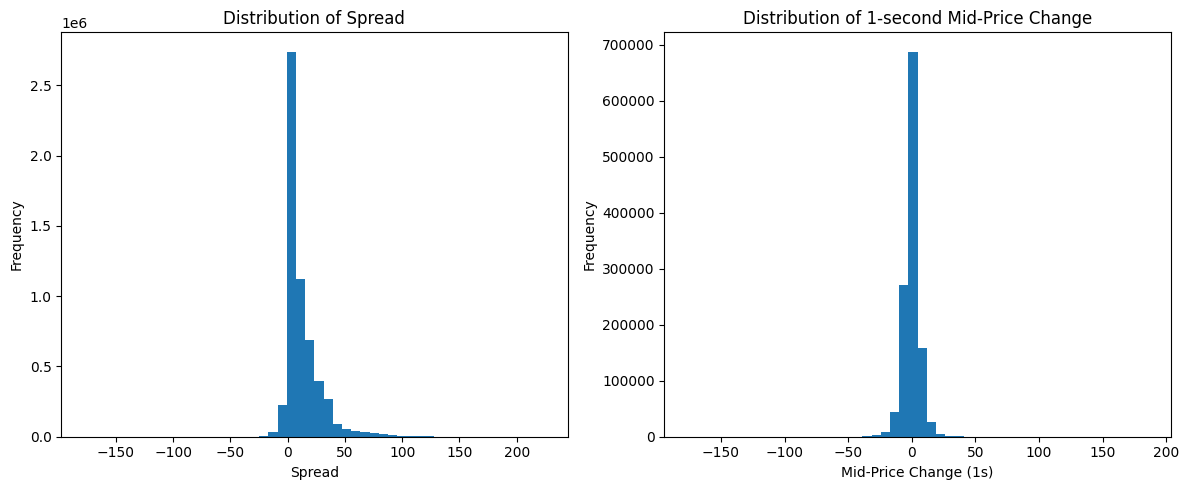

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(combined_df['spread'], bins=50)
plt.title('Distribution of Spread')
plt.xlabel('Spread')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(mid_price_1s['mid_price_change_1s'].dropna(), bins=50)
plt.title('Distribution of 1-second Mid-Price Change')
plt.xlabel('Mid-Price Change (1s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# Define up/down label based on next 1-second mid-price
mid = mid_price_1s['average_mid_price_1s']
future_mid = mid.shift(-1)
label_up = (future_mid > mid).astype(int)
mid_price_1s['label_up'] = label_up

# Drop rows where label is NaN (typically last row)
mid_price_1s = mid_price_1s.dropna(subset=['label_up'])

# Aggregate microstructure features to 1-second level
features_1s = combined_df.resample('1S').agg({
    'spread': 'mean',
    'best_bid_quantity': 'sum',
    'best_ask_quantity': 'sum',
    'mid_price': 'last'
})

# Order book imbalance
features_1s['imbalance'] = (
    features_1s['best_bid_quantity'] - features_1s['best_ask_quantity']
) / (features_1s['best_bid_quantity'] + features_1s['best_ask_quantity'] + 1e-9)

# Short-term mid-price return
features_1s['mid_return_1s'] = features_1s['mid_price'].pct_change()

# Join features with labels on timestamp
dataset_1s = features_1s.join(mid_price_1s[['label_up']], how='inner')
dataset_1s = dataset_1s.dropna()

len(dataset_1s)
dataset_1s.index.min(), dataset_1s.index.max()

print('Final dataset shape:', dataset_1s.shape)
display(dataset_1s.head())

C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\2970685040.py:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  features_1s = combined_df.resample('1S').agg({


Final dataset shape: (1208691, 7)


C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\2970685040.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features_1s['mid_return_1s'] = features_1s['mid_price'].pct_change()


,spread,best_bid_quantity,best_ask_quantity,mid_price,imbalance,mid_return_1s,label_up
ts,,,,,,,
2025-09-01 00:00:02,0.84,1.346277,2.943306,108241.75,-0.372304,0.000000,1
2025-09-01 00:00:03,0.86,5.333104,3.638502,108249.15,0.188885,0.000068,1
2025-09-01 00:00:04,11.68,4.460089,4.902375,108253.85,-0.047240,0.000043,1
2025-09-01 00:00:05,9.24,1.082371,5.086108,108249.15,-0.649064,-0.000043,0
2025-09-01 00:00:06,4.18,3.839207,6.202640,108242.25,-0.235358,-0.000064,1


In [14]:
# === SVM-specific subset to keep training fast ===

from sklearn.preprocessing import StandardScaler

# --- Strategy C: downsample the full 2-week dataset ---
# Take every 5th row (i.e., 5-second spacing if resampled at 1s)
svm_subset = dataset_1s.iloc[::5].copy()

print("Full dataset size:", len(dataset_1s))
print("SVM subset size (downsampled):", len(svm_subset))

# OPTIONAL: Strategy B instead (comment this in and comment the downsample line out above)
# Example: use only a 2-day window
# svm_subset = dataset_1s.loc['2025-09-03':'2025-09-04'].copy()
# print("SVM subset (2 days) size:", len(svm_subset))

# --- Build features and labels for SVM ---
feature_cols = ['spread', 'best_bid_quantity', 'best_ask_quantity',
                'imbalance', 'mid_return_1s']

X_svm = svm_subset[feature_cols].values
y_svm = svm_subset['label_up'].values

# Time-based train/test split: first 80% train, last 20% test
n_svm = len(X_svm)
split_idx_svm = int(n_svm * 0.8)

X_svm_train, X_svm_test = X_svm[:split_idx_svm], X_svm[split_idx_svm:]
y_svm_train, y_svm_test = y_svm[:split_idx_svm], y_svm[split_idx_svm:]

print("SVM train size:", X_svm_train.shape[0])
print("SVM test size:", X_svm_test.shape[0])

# Scale features for SVM
scaler_svm = StandardScaler()
X_svm_train_scaled = scaler_svm.fit_transform(X_svm_train)
X_svm_test_scaled = scaler_svm.transform(X_svm_test)


Full dataset size: 1208691
SVM subset size (downsampled): 241739
SVM train size: 193391
SVM test size: 48348


In [15]:
# Features and labels
feature_cols = ['spread', 'best_bid_quantity', 'best_ask_quantity', 'imbalance', 'mid_return_1s']
X = dataset_1s[feature_cols].values
y = dataset_1s['label_up'].values

# Time-based split: first 80% train, last 20% test
n_samples = len(X)
split_idx = int(n_samples * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print('Train size:', X_train.shape[0])
print('Test size:', X_test.shape[0])

# Standardize features (important for SVM, okay for trees)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train size: 966952
Test size: 241739


In [19]:
# === ADVANCED FEATURE SELECTION ===
advanced_feature_cols = [
    # Basic microstructure
    'spread', 'spread_bps', 'price_imbalance', 'microprice',
    # Volatility
    'volatility_10', 'volatility_50', 'realized_variance_10',
    # Order flow
    'ofi_proxy', 'volume_concentration', 'price_pressure',
    # Momentum
    'mid_return_lag_1', 'mid_return_lag_5',
    # Liquidity
    'liquidity_imbalance', 'depth_cost',
    # Statistical
    'return_skew_30', 'volume_imbalance_ma_30'
]

# Add time features if available
if 'hour' in enhanced_df.columns:
    advanced_feature_cols.extend(['hour', 'asian_session', 'european_session', 'us_session'])

print(f"Using {len(advanced_feature_cols)} advanced features")

Using 20 advanced features


In [20]:
# === ADVANCED MODELS WITH ENHANCED FEATURES ===
def train_advanced_models(X_train, X_test, y_train, y_test, feature_names):
    """Train XGBoost and LightGBM with enhanced features"""
    models = {}
    
    # XGBoost
    models['xgb'] = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    # LightGBM
    models['lgb'] = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
    
    # Train and evaluate
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"{name.upper()} Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        print("-" * 50)
    
    return models

# Prepare enhanced dataset (make sure to handle NaNs)
X_enhanced = enhanced_df[advanced_feature_cols].values
y_enhanced = enhanced_df['label_up'].values

# Handle NaN values
nan_mask = ~np.isnan(X_enhanced).any(axis=1)
X_enhanced = X_enhanced[nan_mask]
y_enhanced = y_enhanced[nan_mask]

# Time-based split
n_enhanced = len(X_enhanced)
split_idx_enhanced = int(n_enhanced * 0.8)

X_train_enh, X_test_enh = X_enhanced[:split_idx_enhanced], X_enhanced[split_idx_enhanced:]
y_train_enh, y_test_enh = y_enhanced[:split_idx_enhanced], y_enhanced[split_idx_enhanced:]

# Scale and train
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

print("Training advanced models with enhanced features...")
advanced_models = train_advanced_models(X_train_enh_scaled, X_test_enh_scaled, y_train_enh, y_test_enh, advanced_feature_cols)

Training advanced models with enhanced features...
Training xgb...
XGB Accuracy: 0.6168
              precision    recall  f1-score   support

           0       0.62      0.73      0.67    130590
           1       0.60      0.48      0.54    111147

    accuracy                           0.62    241737
   macro avg       0.61      0.61      0.61    241737
weighted avg       0.62      0.62      0.61    241737

--------------------------------------------------
Training lgb...


C:\Users\nicka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGB Accuracy: 0.6172
              precision    recall  f1-score   support

           0       0.62      0.74      0.67    130590
           1       0.61      0.48      0.53    111147

    accuracy                           0.62    241737
   macro avg       0.61      0.61      0.60    241737
weighted avg       0.62      0.62      0.61    241737

--------------------------------------------------


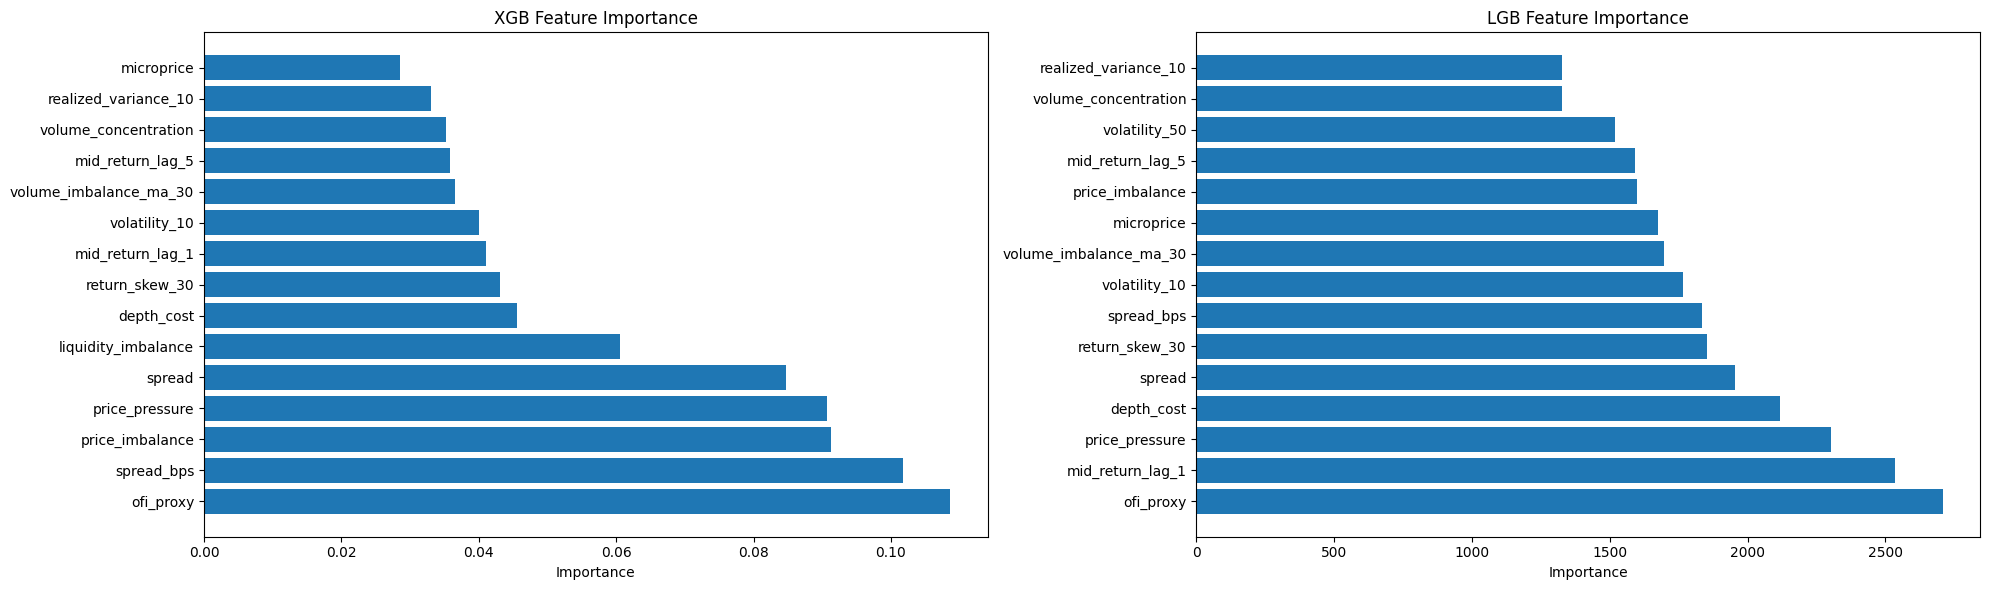

In [21]:
# === FEATURE IMPORTANCE ANALYSIS ===
def plot_feature_importance(models, feature_names, top_n=15):
    """Plot feature importance from different models"""
    fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
    
    for idx, (name, model) in enumerate(models.items()):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            # Use permutation importance as fallback
            result = permutation_importance(
                model, X_test_enh_scaled, y_test_enh, 
                n_repeats=5, random_state=42
            )
            importances = result.importances_mean
        
        # Get top N features
        indices = np.argsort(importances)[::-1][:top_n]
        
        axes[idx].barh(range(top_n), importances[indices])
        axes[idx].set_yticks(range(top_n))
        axes[idx].set_yticklabels([feature_names[i] for i in indices])
        axes[idx].set_title(f'{name.upper()} Feature Importance')
        axes[idx].set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(advanced_models, advanced_feature_cols)

In [13]:
# Random Forest baseline
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)

print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.5968379119629021
              precision    recall  f1-score   support

           0       0.61      0.55      0.58    120794
           1       0.59      0.64      0.61    120945

    accuracy                           0.60    241739
   macro avg       0.60      0.60      0.60    241739
weighted avg       0.60      0.60      0.60    241739



In [14]:
# SVM with Linear Kernel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and train Linear SVM
lin_svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=5000,
    random_state=42
)

lin_svm.fit(X_svm_train_scaled, y_svm_train)

# Predictions
y_pred_lin = lin_svm.predict(X_svm_test_scaled)

# Evaluation
print("Linear SVM (on subset)")
print("Accuracy:", accuracy_score(y_svm_test, y_pred_lin))
print("\nClassification report:")
print(classification_report(y_svm_test, y_pred_lin))

print("\nConfusion matrix:")
print(confusion_matrix(y_svm_test, y_pred_lin))


Linear SVM (on subset)
Accuracy: 0.5212625134441963

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.49      0.50     24251
           1       0.52      0.56      0.54     24097

    accuracy                           0.52     48348
   macro avg       0.52      0.52      0.52     48348
weighted avg       0.52      0.52      0.52     48348


Confusion matrix:
[[11766 12485]
 [10661 13436]]


In [15]:
# SVM with RBF kernel
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# --- Option 1: RBF SVM (still heavy, but now on a MUCH smaller subset) ---
svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    max_iter=5000,       # optional safety cap
    random_state=42
)

svm_clf.fit(X_svm_train_scaled, y_svm_train)
y_pred_svm = svm_clf.predict(X_svm_test_scaled)

print("RBF SVM on subset")
print("Accuracy:", accuracy_score(y_svm_test, y_pred_svm))
print(classification_report(y_svm_test, y_pred_svm))


C:\Users\nicka\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RBF SVM on subset
Accuracy: 0.5046330768594357
              precision    recall  f1-score   support

           0       0.50      0.99      0.67     24251
           1       0.65      0.01      0.03     24097

    accuracy                           0.50     48348
   macro avg       0.58      0.50      0.35     48348
weighted avg       0.58      0.50      0.35     48348



In [16]:
# Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_clf.fit(X_train_scaled, y_train)
y_pred_gb = gb_clf.predict(X_test_scaled)

print('Gradient Boosting Accuracy:', accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.5966434873975651
              precision    recall  f1-score   support

           0       0.60      0.57      0.59    120794
           1       0.59      0.62      0.61    120945

    accuracy                           0.60    241739
   macro avg       0.60      0.60      0.60    241739
weighted avg       0.60      0.60      0.60    241739



In [24]:
# === TRAIN ALL MODELS ON ENHANCED FEATURES ===
print("Training all models with enhanced features...")

# Prepare the enhanced dataset for training
X_enhanced = enhanced_df[advanced_feature_cols].values
y_enhanced = enhanced_df['label_up'].values

# Handle NaN values
nan_mask = ~np.isnan(X_enhanced).any(axis=1)
X_enhanced = X_enhanced[nan_mask]
y_enhanced = y_enhanced[nan_mask]

# Time-based split
n_enhanced = len(X_enhanced)
split_idx_enhanced = int(n_enhanced * 0.8)

X_train_enh, X_test_enh = X_enhanced[:split_idx_enhanced], X_enhanced[split_idx_enhanced:]
y_train_enh, y_test_enh = y_enhanced[:split_idx_enhanced], y_enhanced[split_idx_enhanced:]

# Scale features
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

print(f"Enhanced train size: {X_train_enh.shape[0]}")
print(f"Enhanced test size: {X_test_enh.shape[0]}")

# Define all models
models = {}

# 1. Random Forest
models['rf'] = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# 2. Gradient Boosting
models['gb'] = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# 3. XGBoost
models['xgb'] = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 4. LightGBM
models['lgb'] = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Train all models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_enh_scaled, y_train_enh)
    y_pred = model.predict(X_test_enh_scaled)
    accuracy = accuracy_score(y_test_enh, y_pred)
    print(f"{name.upper()} Accuracy: {accuracy:.4f}")

print("All models trained successfully!")

Training all models with enhanced features...
Enhanced train size: 966945
Enhanced test size: 241737
Training rf...
RF Accuracy: 0.6050
Training gb...
GB Accuracy: 0.6085
Training xgb...
XGB Accuracy: 0.6168
Training lgb...


C:\Users\nicka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGB Accuracy: 0.6172
All models trained successfully!


In [25]:
# === COMPREHENSIVE MODEL EVALUATION ===
print("Performing comprehensive model evaluation...")

def evaluate_model_performance(y_true, y_pred, model_name):
    """Comprehensive model evaluation metrics"""
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate profit/loss if we traded based on predictions
    correct_predictions = (y_true == y_pred)
    profit = correct_predictions.sum() - (len(y_true) - correct_predictions.sum())
    profit_percentage = profit / len(y_true) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Profit Simulation: ${profit} ({profit_percentage:.2f}% return)")
    print(f"Confusion Matrix:\n{cm}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'profit': profit,
        'profit_percentage': profit_percentage
    }

# Evaluate all models
model_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_enh_scaled)
    model_results[name] = evaluate_model_performance(y_test_enh, y_pred, name.upper())

Performing comprehensive model evaluation...

RF Performance:
Accuracy: 0.6050
Precision: 0.5882
Recall: 0.4700
F1-Score: 0.5225
Profit Simulation: $50787 (21.01% return)
Confusion Matrix:
[[94019 36571]
 [58904 52243]]

GB Performance:
Accuracy: 0.6085
Precision: 0.5918
Recall: 0.4784
F1-Score: 0.5291
Profit Simulation: $52445 (21.70% return)
Confusion Matrix:
[[93921 36669]
 [57977 53170]]

XGB Performance:
Accuracy: 0.6168
Precision: 0.6043
Recall: 0.4827
F1-Score: 0.5367
Profit Simulation: $56491 (23.37% return)
Confusion Matrix:
[[95463 35127]
 [57496 53651]]


C:\Users\nicka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LGB Performance:
Accuracy: 0.6172
Precision: 0.6062
Recall: 0.4783
F1-Score: 0.5347
Profit Simulation: $56687 (23.45% return)
Confusion Matrix:
[[96048 34542]
 [57983 53164]]


In [26]:
# === BACKTESTING FRAMEWORK ===
print("\n" + "="*50)
print("BACKTESTING RESULTS")
print("="*50)

def backtest_strategy(df, predictions, initial_capital=10000, bet_size=100):
    """
    Backtest a trading strategy based on model predictions
    
    Simple strategy:
    - If model predicts UP (1): bet on price increase
    - If model predicts DOWN (0): do nothing or bet against (short)
    """
    # Ensure we're working with aligned data
    backtest_df = df.copy()
    backtest_df = backtest_df.iloc[-len(predictions):]  # Align with predictions
    backtest_df['prediction'] = predictions
    
    # Calculate returns
    backtest_df['actual_return'] = backtest_df['mid_price'].pct_change().shift(-1)
    backtest_df['strategy_return'] = backtest_df['prediction'] * backtest_df['actual_return']
    
    # Remove the last row (no future return)
    backtest_df = backtest_df.dropna(subset=['actual_return'])
    
    # Calculate cumulative returns
    backtest_df['cumulative_market'] = (1 + backtest_df['actual_return']).cumprod()
    backtest_df['cumulative_strategy'] = (1 + backtest_df['strategy_return']).cumprod()
    
    # Calculate performance metrics
    total_market_return = backtest_df['cumulative_market'].iloc[-1] - 1
    total_strategy_return = backtest_df['cumulative_strategy'].iloc[-1] - 1
    
    # Risk metrics
    strategy_volatility = backtest_df['strategy_return'].std() * np.sqrt(252 * 86400)  # Annualized
    market_volatility = backtest_df['actual_return'].std() * np.sqrt(252 * 86400)
    
    # Sharpe ratio (assuming 0 risk-free rate for simplicity)
    sharpe_ratio = total_strategy_return / strategy_volatility if strategy_volatility > 0 else 0
    
    # Maximum drawdown
    cumulative_max = backtest_df['cumulative_strategy'].expanding().max()
    drawdown = (backtest_df['cumulative_strategy'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    
    # Win rate
    winning_trades = (backtest_df['strategy_return'] > 0).sum()
    total_trades = (backtest_df['prediction'] == 1).sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    return backtest_df, {
        'total_market_return': total_market_return,
        'total_strategy_return': total_strategy_return,
        'excess_return': total_strategy_return - total_market_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'total_trades': total_trades,
        'winning_trades': winning_trades
    }

# Backtest each model
backtest_results = {}

print("Backtesting strategies...")
for model_name, model in list(advanced_models.items()) + [('rf', models['rf']), ('gb', models['gb'])]:
    # Get predictions
    if model_name in ['rf', 'gb']:
        predictions = model.predict(X_test_enh_scaled)
    else:
        predictions = model.predict(X_test_enh_scaled)
    
    # Run backtest
    backtest_df, metrics = backtest_strategy(enhanced_df, predictions)
    backtest_results[model_name] = metrics
    
    print(f"\n{model_name.upper()} Backtest Results:")
    print(f"  Total Strategy Return: {metrics['total_strategy_return']:.4f} ({metrics['total_strategy_return']*100:.2f}%)")
    print(f"  Total Market Return: {metrics['total_market_return']:.4f} ({metrics['total_market_return']*100:.2f}%)")
    print(f"  Excess Return: {metrics['excess_return']:.4f} ({metrics['excess_return']*100:.2f}%)")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
    print(f"  Max Drawdown: {metrics['max_drawdown']:.4f} ({metrics['max_drawdown']*100:.2f}%)")
    print(f"  Win Rate: {metrics['win_rate']:.4f} ({metrics['winning_trades']}/{metrics['total_trades']})")


BACKTESTING RESULTS
Backtesting strategies...


C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\3109681312.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  backtest_df['actual_return'] = backtest_df['mid_price'].pct_change().shift(-1)
C:\Users\nicka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



XGB Backtest Results:
  Total Strategy Return: 0.0988 (9.88%)
  Total Market Return: -0.0004 (-0.04%)
  Excess Return: 0.0992 (9.92%)
  Sharpe Ratio: 0.3325
  Max Drawdown: -0.0210 (-2.10%)
  Win Rate: 0.4650 (41281/88777)


C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\3109681312.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  backtest_df['actual_return'] = backtest_df['mid_price'].pct_change().shift(-1)



LGB Backtest Results:
  Total Strategy Return: 0.0895 (8.95%)
  Total Market Return: -0.0004 (-0.04%)
  Excess Return: 0.0899 (8.99%)
  Sharpe Ratio: 0.3003
  Max Drawdown: -0.0203 (-2.03%)
  Win Rate: 0.4643 (40724/87705)


C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\3109681312.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  backtest_df['actual_return'] = backtest_df['mid_price'].pct_change().shift(-1)



RF Backtest Results:
  Total Strategy Return: 0.0447 (4.47%)
  Total Market Return: -0.0004 (-0.04%)
  Excess Return: 0.0451 (4.51%)
  Sharpe Ratio: 0.1457
  Max Drawdown: -0.0275 (-2.75%)
  Win Rate: 0.4633 (41145/88814)

GB Backtest Results:
  Total Strategy Return: 0.0718 (7.18%)
  Total Market Return: -0.0004 (-0.04%)
  Excess Return: 0.0722 (7.22%)
  Sharpe Ratio: 0.2320
  Max Drawdown: -0.0252 (-2.52%)
  Win Rate: 0.4643 (41709/89839)


C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\3109681312.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  backtest_df['actual_return'] = backtest_df['mid_price'].pct_change().shift(-1)


C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\3109681312.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  backtest_df['actual_return'] = backtest_df['mid_price'].pct_change().shift(-1)
C:\Users\nicka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\3109681312.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  backtest_df['actual_return'] = backtest_df['mid_price'].pct_change().shift(-1)
C:\U

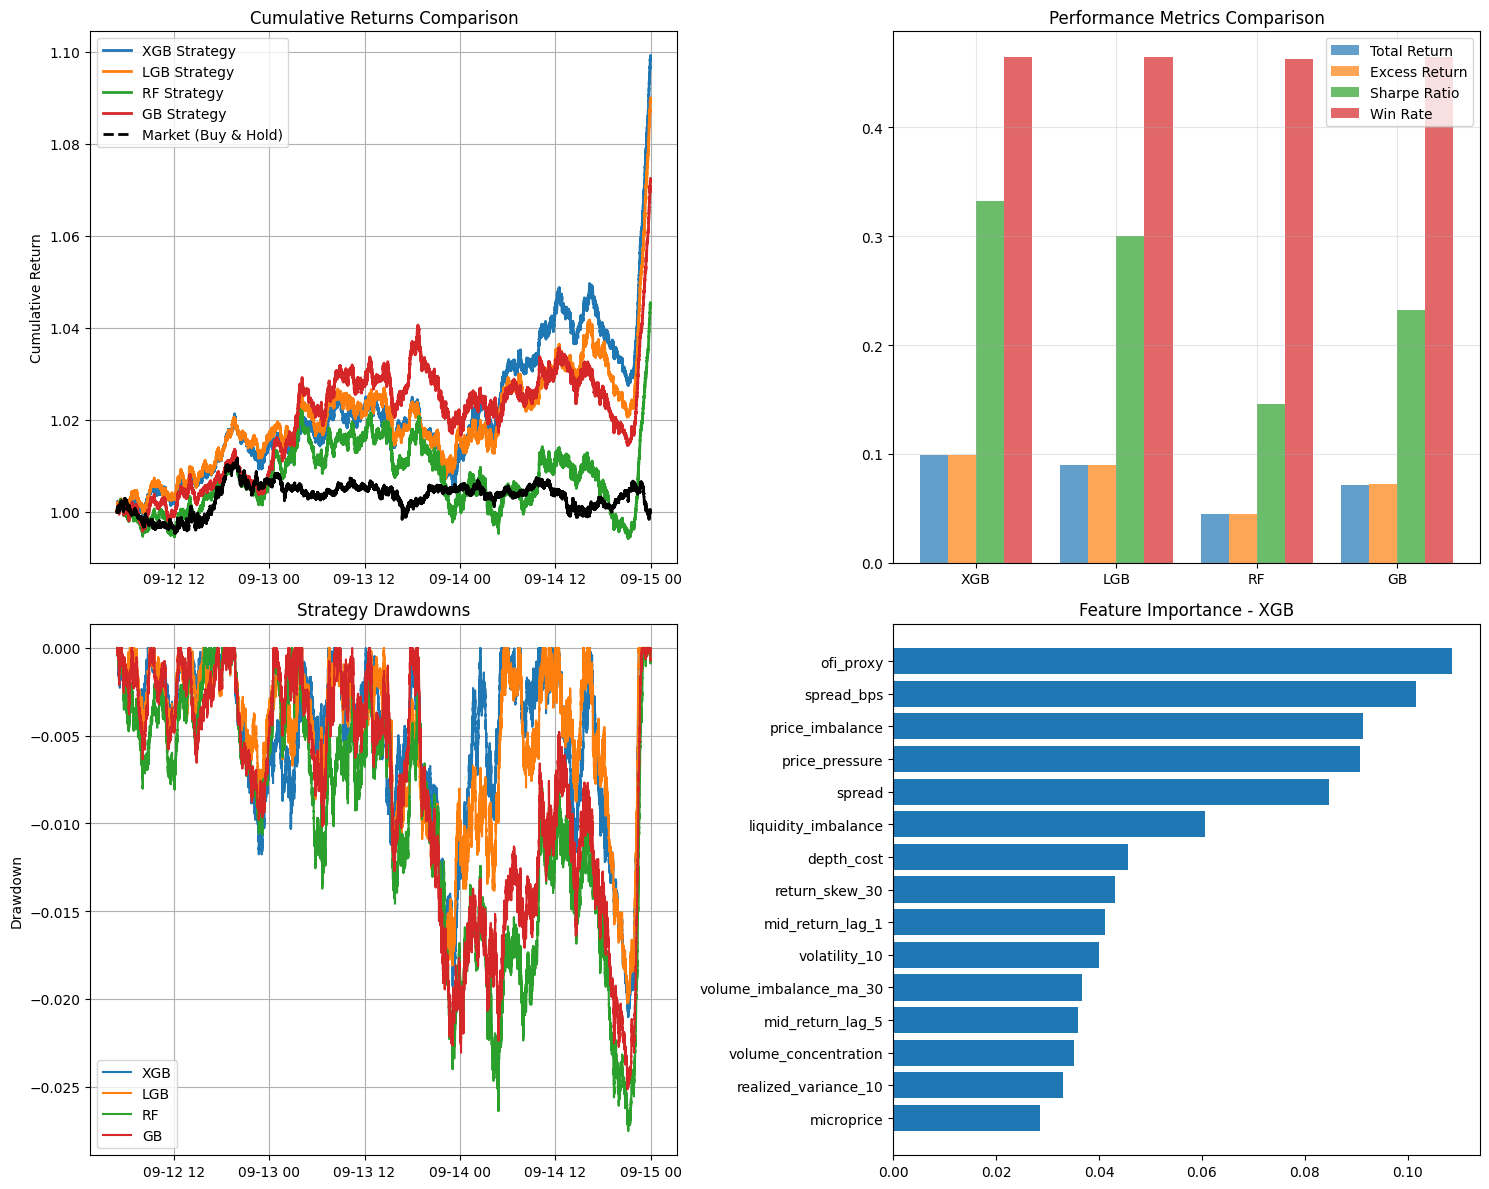

In [27]:
# === VISUALIZE BACKTESTING RESULTS ===
import matplotlib.pyplot as plt

def plot_backtest_results(backtest_results, backtest_dfs):
    """Plot comparative backtest results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Cumulative Returns Comparison
    for model_name, backtest_df in backtest_dfs.items():
        axes[0, 0].plot(backtest_df.index, backtest_df['cumulative_strategy'], 
                       label=f'{model_name.upper()} Strategy', linewidth=2)
    
    # Add market benchmark
    sample_df = list(backtest_dfs.values())[0]
    axes[0, 0].plot(sample_df.index, sample_df['cumulative_market'], 
                   label='Market (Buy & Hold)', linewidth=2, linestyle='--', color='black')
    
    axes[0, 0].set_title('Cumulative Returns Comparison')
    axes[0, 0].set_ylabel('Cumulative Return')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot 2: Performance Metrics Comparison
    metrics_to_plot = ['total_strategy_return', 'excess_return', 'sharpe_ratio', 'win_rate']
    metric_names = ['Total Return', 'Excess Return', 'Sharpe Ratio', 'Win Rate']
    
    for i, metric in enumerate(metrics_to_plot):
        values = [backtest_results[model][metric] for model in backtest_results.keys()]
        axes[0, 1].bar(np.arange(len(values)) + i*0.2, values, width=0.2, 
                      label=metric_names[i], alpha=0.7)
    
    axes[0, 1].set_title('Performance Metrics Comparison')
    axes[0, 1].set_xticks(np.arange(len(backtest_results)) + 0.3)
    axes[0, 1].set_xticklabels([name.upper() for name in backtest_results.keys()])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Drawdown Analysis
    for model_name, backtest_df in backtest_dfs.items():
        cumulative_max = backtest_df['cumulative_strategy'].expanding().max()
        drawdown = (backtest_df['cumulative_strategy'] - cumulative_max) / cumulative_max
        axes[1, 0].plot(backtest_df.index, drawdown, label=f'{model_name.upper()}')
    
    axes[1, 0].set_title('Strategy Drawdowns')
    axes[1, 0].set_ylabel('Drawdown')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot 4: Feature Importance (for best model)
    best_model_name = max(backtest_results.keys(), 
                         key=lambda x: backtest_results[x]['total_strategy_return'])
    best_model = advanced_models.get(best_model_name, models.get(best_model_name))
    
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[-15:]  # Top 15 features
        
        axes[1, 1].barh(range(len(indices)), importances[indices])
        axes[1, 1].set_yticks(range(len(indices)))
        axes[1, 1].set_yticklabels([advanced_feature_cols[i] for i in indices])
        axes[1, 1].set_title(f'Feature Importance - {best_model_name.upper()}')
    
    plt.tight_layout()
    plt.show()

# Run backtests and store dataframes
backtest_dfs = {}
for model_name, model in list(advanced_models.items()) + [('rf', models['rf']), ('gb', models['gb'])]:
    if model_name in ['rf', 'gb']:
        predictions = model.predict(X_test_enh_scaled)
    else:
        predictions = model.predict(X_test_enh_scaled)
    
    backtest_df, _ = backtest_strategy(enhanced_df, predictions)
    backtest_dfs[model_name] = backtest_df

# Plot results
plot_backtest_results(backtest_results, backtest_dfs)

In [28]:
# === TRADING STRATEGY ANALYSIS ===
print("\n" + "="*50)
print("TRADING STRATEGY ANALYSIS")
print("="*50)

def analyze_trading_patterns(backtest_df, model_name):
    """Analyze when the strategy works best"""
    
    # Analyze by time of day
    if 'hour' in backtest_df.columns:
        hourly_performance = backtest_df.groupby('hour').agg({
            'strategy_return': 'mean',
            'prediction': 'count'
        }).rename(columns={'strategy_return': 'avg_return', 'prediction': 'trade_count'})
        
        print(f"\n{model_name.upper()} - Hourly Performance:")
        print(hourly_performance.round(6))
    
    # Analyze market regime performance
    volatility_regimes = pd.cut(backtest_df['volatility_10'], 
                               bins=[0, backtest_df['volatility_10'].quantile(0.33), 
                                   backtest_df['volatility_10'].quantile(0.66), 
                                   backtest_df['volatility_10'].max()],
                               labels=['Low Vol', 'Medium Vol', 'High Vol'])
    
    regime_performance = backtest_df.groupby(volatility_regimes).agg({
        'strategy_return': 'mean',
        'actual_return': 'mean',
        'prediction': 'count'
    })
    
    print(f"\n{model_name.upper()} - Volatility Regime Performance:")
    print(regime_performance.round(6))

# Analyze best performing model
best_model_name = max(backtest_results.keys(), 
                     key=lambda x: backtest_results[x]['total_strategy_return'])
best_backtest_df = backtest_dfs[best_model_name]

analyze_trading_patterns(best_backtest_df, best_model_name)

# Summary
print(f"\n{'='*50}")
print("SUMMARY")
print(f"{'='*50}")
print(f"Best Performing Model: {best_model_name.upper()}")
print(f"Best Model Return: {backtest_results[best_model_name]['total_strategy_return']*100:.2f}%")
print(f"Excess Return vs Market: {backtest_results[best_model_name]['excess_return']*100:.2f}%")
print(f"Win Rate: {backtest_results[best_model_name]['win_rate']*100:.2f}%")


TRADING STRATEGY ANALYSIS

XGB - Hourly Performance:
      avg_return  trade_count
hour                         
0       0.000001         7201
1      -0.000000         7200
2       0.000001         7200
3      -0.000000         7200
4       0.000001         7735
5       0.000000        10800
6       0.000000        10800
7       0.000000        10800
8       0.000001        10800
9       0.000000        10800
10     -0.000000        10800
11      0.000000        10800
12      0.000000        10800
13     -0.000001        10800
14     -0.000001        10800
15      0.000001        10800
16      0.000000        10800
17      0.000000        10800
18     -0.000000        10800
19     -0.000000        10800
20     -0.000001        10800
21     -0.000001        10800
22      0.000002        10800
23      0.000004        10800

XGB - Volatility Regime Performance:
               strategy_return  actual_return  prediction
volatility_10                                            
Low Vol     

C:\Users\nicka\AppData\Local\Temp\ipykernel_32684\253155640.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_performance = backtest_df.groupby(volatility_regimes).agg({
